### File: Model Optimization

##### Goals and Objectives of this file:

##### 1. Basic Model Training and Word Embedding Testing
##### 2. Data Processing => over/under sampling the classes  =>  word embeddings => feature selection
##### 3. Model Optimization => (Hyper)parameter Tuning => different Algorithms tests => different neural network architectures test
##### 4. Training and Testing => accuracy => precision => confusion matrix => roc/auc curves => learning curve

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import imblearn
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### 1. Basic Model Training and Vectorizer Testing

In [2]:
df = pd.read_csv("datasets/yelp coffee/raw_yelp_review_data_processed.csv")

In [3]:
X = df['full_review_text']
y = df['star_rating']

In [4]:
def create_data_split(X,y,vectorizer=False):
    x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2,random_state = 42)
    if vectorizer:
        vectorizer = vectorizer
        train_embed = vectorizer.fit_transform(x_train)
        test_embed = vectorizer.transform(x_test)
        return train_embed,test_embed,y_train,y_test
    else:
        return x_train,x_test,y_train,y_test

In [5]:
x_train_tfidf,x_test_tfidf,y_train,y_test = create_data_split(X,y,TfidfVectorizer())

In [6]:
model_NB = MultinomialNB()
model_NB.fit(x_train_tfidf, y_train)
accuracy = model_NB.score(x_test_tfidf, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 47.94%


### This result can be better...

### 2. Data Processing

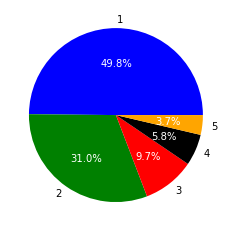

In [7]:
_, _, autotexts = plt.pie(y.value_counts(),colors = ['blue','green','red','black','orange'],labels = [1,2,3,4,5],autopct= '%1.1f%%')
for autotext in autotexts:
    autotext.set_color('white')

### This dataset will be balanced using several different techniques.

### 2.1 Data Resampling

#### Random Oversampling

In [8]:
random_oversampler = RandomOverSampler(random_state=42)
ro_x_tfidf,ro_y = random_oversampler.fit_resample(x_train_tfidf, y_train)

In [9]:
ro_y.value_counts()

5    2784
1    2784
3    2784
4    2784
2    2784
Name: star_rating, dtype: int64

In [10]:
model_NB = MultinomialNB()
model_NB.fit(ro_x_tfidf, ro_y)
accuracy = model_NB.score(x_test_tfidf, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 55.17%


#### Random Undersampling

In [11]:
random_underSampler = RandomUnderSampler(random_state=42)
ru_x_tfidf,ru_y = random_underSampler.fit_resample(x_train_tfidf, y_train)

In [12]:
ru_y.value_counts()

1    195
2    195
3    195
4    195
5    195
Name: star_rating, dtype: int64

In [13]:
model_NB = MultinomialNB()
model_NB.fit(ru_x_tfidf, ru_y)
accuracy = model_NB.score(x_test_tfidf, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 43.60%


#### SMOTE

In [14]:
oversample = SMOTE(random_state=42)
smote_x_tfidf,smote_y = oversample.fit_resample(x_train_tfidf, y_train)

In [15]:
smote_y.value_counts()

5    2784
1    2784
3    2784
4    2784
2    2784
Name: star_rating, dtype: int64

In [16]:
model_NB = MultinomialNB()
model_NB.fit(smote_x_tfidf, smote_y)
accuracy = model_NB.score(x_test_tfidf, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 52.28%


### According to the accuracy results: Random Oversampling was the best method for data resampling.

### 2.2 Word Embeddings

### Word2Vec (BoW)

In [17]:
bow_vectorizer = CountVectorizer(encoding = 'utf-8')
bow_matrix = bow_vectorizer.fit_transform(X)
bow_array = bow_matrix.toarray()
bow_df = pd.DataFrame(data=bow_array,columns = bow_vectorizer.vocabulary_.keys())

In [18]:
bow_df.head()

,love,loved,atmosphere,corner,coffee,shop,style,swing,ordered,matcha,...,deliciousand,rustica,romaine,predictably,roomier,windowed,actuality,crass,budha,digestion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#bow_df.describe()

In [20]:
(bow_df['love'] != 0).sum()

8

### TF-IDF 

In [21]:
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_matrix = tf_idf_vectorizer.fit_transform(X)
tf_idf_array = bow_matrix.toarray()
tf_idf_df = pd.DataFrame(data=tf_idf_array,columns=bow_vectorizer.vocabulary_.keys())

In [22]:
tf_idf_df.head()

,love,loved,atmosphere,corner,coffee,shop,style,swing,ordered,matcha,...,deliciousand,rustica,romaine,predictably,roomier,windowed,actuality,crass,budha,digestion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#tf_idf_df.describe()

In [24]:
(tf_idf_df['love'] != 0).sum()

8

### Word2Vec vs TF-IDF (with Random Resampling)

In [25]:
random_oversampler = RandomOverSampler(random_state=42)

In [26]:
x_train_bow,x_test_bow,y_train,y_test = create_data_split(X,y,vectorizer=CountVectorizer())
ro_x_bow,ro_y = random_oversampler.fit_resample(x_train_bow, y_train)
model_NB = MultinomialNB()
model_NB.fit(ro_x_bow, ro_y)
accuracy = model_NB.score(x_test_bow, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 56.18%


In [27]:
x_train_tfidf,x_test_tfidf,y_train,y_test = create_data_split(X,y,vectorizer=TfidfVectorizer())
ro_x_tfidf,ro_y = random_oversampler.fit_resample(x_train_tfidf, y_train)
model_NB = MultinomialNB()
model_NB.fit(ro_x_tfidf, ro_y)
accuracy = model_NB.score(x_test_tfidf, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 55.17%


### Based on the previous results: Word2Vec Outperformed TF-IDF

### Before moving on to Feature Selection, the best resampling technique must found for Word2Vec

In [28]:
random_underSampler = RandomUnderSampler(random_state=42)

In [29]:
ru_x_bow,ru_y = random_underSampler.fit_resample(x_train_bow, y_train)
model_NB = MultinomialNB()
model_NB.fit(ru_x_bow, ru_y)
accuracy = model_NB.score(x_test_bow, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 39.84%


In [30]:
oversample = SMOTE(random_state=42)

In [31]:
smote_x_bow,smote_y = oversample.fit_resample(x_train_bow, y_train)
model_NB = MultinomialNB()
model_NB.fit(smote_x_bow, smote_y)
accuracy = model_NB.score(x_test_bow, y_test)
print("Model accuracy: {:.2f}%".format(accuracy * 100))

Model accuracy: 58.42%


In [32]:
y_pred = model_NB.predict(x_test_bow)
print("Random Forest Classification Report = \n ",metrics.classification_report(y_test,y_pred))

Random Forest Classification Report = 
                precision    recall  f1-score   support

           1       0.70      0.28      0.40        58
           2       0.31      0.24      0.27        70
           3       0.40      0.24      0.30       134
           4       0.51      0.54      0.52       459
           5       0.67      0.75      0.71       662

    accuracy                           0.58      1383
   macro avg       0.52      0.41      0.44      1383
weighted avg       0.57      0.58      0.57      1383



### Based on these results: SMOTE was the best resampling technique specifically for Word2Vec

### 2.3 Feature Selection

In [33]:
bow_df.shape

(6914, 18235)